In [3]:
df1= pd.read_csv('twitter_training.csv')
df2= pd.read_csv('twitter_validation.csv')




In [4]:
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout, LSTM, Embedding, GRU
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
columns_to_drop = ['2401', 'Borderlands']
df1 = df1.drop(columns=columns_to_drop, errors='ignore')
columns_to_drop = ['3364', 'Facebook']
df2 = df2.drop(columns=columns_to_drop, errors='ignore')

In [6]:
columns_mapping = {
    'Positive': 'sentiment',
    'im getting on borderlands and i will murder you all ,': 'Comments'
}

df1= df1.rename(columns= columns_mapping)

columns_mapping = {
    'Irrelevant': 'sentiment',
    'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣': 'Comments'
}

df2= df2.rename(columns= columns_mapping)

In [8]:
df = pd.concat([df1, df2],)
df

,sentiment,Comments
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


In [9]:
df['sentiment']= df['sentiment'].replace('Irrelevant','Neutral')
df['sentiment'].value_counts()

sentiment
Neutral     31764
Negative    22808
Positive    21108
Name: count, dtype: int64

In [10]:
df.dropna(subset= ['Comments'],inplace= True)
df.isnull().sum()

sentiment    0
Comments     0
dtype: int64

In [11]:
df= df.drop_duplicates()
df['sentiment'].value_counts()

sentiment
Neutral     29578
Negative    21329
Positive    19270
Name: count, dtype: int64

In [12]:
import re

def preprocess_text(text):
    # Remove mentions (e.g., @username)
    text = re.sub(r'@\w+', '', text)

    # Remove emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & pictographs
        "\U0001F680-\U0001F6FF"  # Transport & map symbols
        "\U0001F700-\U0001F77F"  # Alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric shapes
        "\U0001F800-\U0001F8FF"  # Miscellaneous Symbols and Arrows
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Extended-A
        "\U0001FA70-\U0001FAFF"  # Extended-B
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"
        "]+"
    )
    text = emoji_pattern.sub(r'', text)

    # Remove other special characters (keep only alphanumeric and spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    return text.strip()

# Apply the preprocessing function to the 'comment' column
df['Comments'] = df['Comments'].apply(preprocess_text)


# Display the updated DataFrame
df

/tmp/ipykernel_47/3368002409.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Comments'] = df['Comments'].apply(preprocess_text)


,sentiment,Comments
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
987,Neutral,Suikoden 2\n1 Alex Kidd in Miracle World\n Per...
988,Positive,Thank you to Matching funds Home Depot RW paym...
990,Neutral,Late night stream with the boys Come watch som...
994,Neutral,Toronto is the arts and culture capital of Can...


In [13]:

df = df[df['Comments'].apply(lambda x: len(x.split()) <= 70)]

# Resetting the index after dropping rows
df.reset_index(drop=True, inplace=True)
df





,sentiment,Comments
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
70151,Neutral,Suikoden 2\n1 Alex Kidd in Miracle World\n Per...
70152,Positive,Thank you to Matching funds Home Depot RW paym...
70153,Neutral,Late night stream with the boys Come watch som...
70154,Neutral,Toronto is the arts and culture capital of Can...


In [14]:
tokenizer= Tokenizer()

Comments= df['Comments'].tolist()
tokenizer.fit_on_texts(Comments)

In [15]:
import pickle
with open('tokenizer.pickle','wb') as handle:
    pickle.dump(tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
sequences= tokenizer.texts_to_sequences(Comments)
print('The max length in Comments is:',max([len(x) for x in sequences]))
print('The Unique word in the Comments are:',len(tokenizer.word_index))

The max length in Comments is: 70
The Unique word in the Comments are: 40758


In [15]:
input_pad_sequences= pad_sequences(sequences,maxlen=70 ,padding= 'pre')

In [17]:
X= input_pad_sequences
y= df['sentiment']


In [18]:
le= LabelEncoder()
y= le.fit_transform(y)

y= to_categorical(y)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56124, 70)
(14032, 70)
(56124, 3)
(14032, 3)


In [20]:

from keras.initializers import glorot_normal

model = Sequential()

# Apply Xavier/Glorot initialization to the Embedding layer
model.add(Embedding(40758, 200, input_length=70, embeddings_initializer=glorot_normal()))

model.add(LSTM(100, return_sequences=True,dropout=0.6 ))


model.add(LSTM(100, return_sequences=True,dropout=0.6 ))

model.add(LSTM(100, return_sequences=True,dropout=0.6 ))


model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))


In [21]:

model.compile(optimizer= 'adam',loss= 'categorical_crossentropy',metrics= ['accuracy'])
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [23]:
history = model.fit(
    X_train, y_train,
    epochs=10, batch_size=32,
    callbacks= callback,

    validation_data=(X_test,y_test))


Epoch 1/10
1754/1754 [==============================] - 47s 27ms/step - loss: 0.6570 - accuracy: 0.7258 - val_loss: 0.4764 - val_accuracy: 0.8158
Epoch 2/10
1754/1754 [==============================] - 33s 19ms/step - loss: 0.3638 - accuracy: 0.8663 - val_loss: 0.3786 - val_accuracy: 0.8578
Epoch 3/10
1754/1754 [==============================] - 31s 18ms/step - loss: 0.2512 - accuracy: 0.9094 - val_loss: 0.3154 - val_accuracy: 0.8818
Epoch 4/10
1754/1754 [==============================] - 31s 18ms/step - loss: 0.1962 - accuracy: 0.9283 - val_loss: 0.3092 - val_accuracy: 0.8931
Epoch 5/10
1754/1754 [==============================] - 30s 17ms/step - loss: 0.1580 - accuracy: 0.9423 - val_loss: 0.2937 - val_accuracy: 0.8986
Epoch 6/10
1754/1754 [==============================] - 31s 18ms/step - loss: 0.1323 - accuracy: 0.9517 - val_loss: 0.3056 - val_accuracy: 0.9029
Epoch 7/10
1754/1754 [==============================] - 30s 17ms/step - loss: 0.1148 - accuracy: 0.9576 - val_loss: 0.3162 -

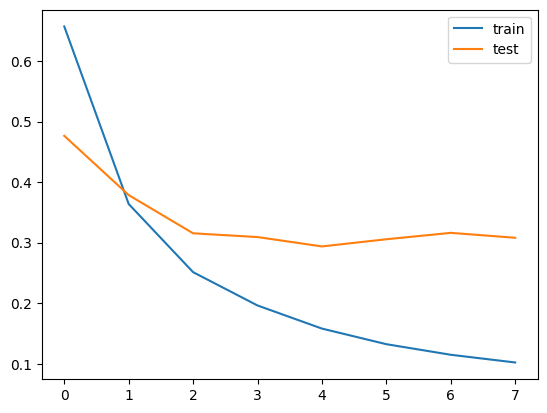

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label= 'train')
plt.plot(history.history['val_loss'],label= 'test')
plt.legend()

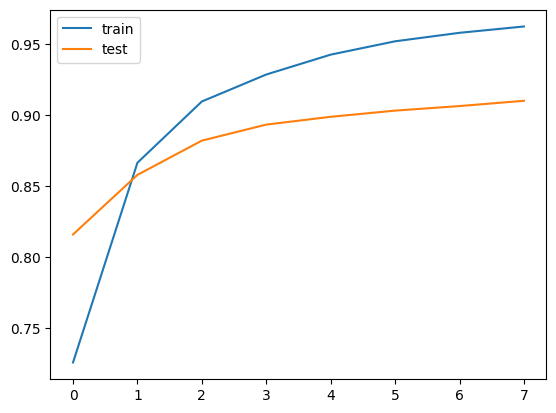

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label= 'train')
plt.plot(history.history['val_accuracy'],label= 'test')
plt.legend()
plt.show()

In [26]:
loss, accuracy= model.evaluate(X_test,y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

439/439 [==============================] - 3s 7ms/step - loss: 0.2937 - accuracy: 0.8986
Test Loss: 0.2937
Test Accuracy: 89.86%


In [27]:
from keras.models import load_model
model.save('sentiment.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
app=load_model('sentiment.h5')
pred=app.predict(X_test)
ans=np.argmax(pred,axis=1)
print(ans)

439/439 [==============================] - 4s 6ms/step
[1 1 0 ... 1 0 2]
